#1.Introduction

#1.1 Load and check data

In [13]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Optional: Style for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [14]:
!pip install -q gdown
import gdown
!mkdir -p data

In [15]:
# Download train.csv
train_file_id = "1yKLc2XZTt3Q3305ehg2fZvqcoSBENvKF"
train_url = f"https://drive.google.com/uc?id={train_file_id}"
gdown.download(train_url, "data/train.csv", quiet=False)

# Download test.csv
test_file_id = "1Mj-TC6mvbI2avK40X46khhkO0cBdV8X3"
test_url = f"https://drive.google.com/uc?id={test_file_id}"
gdown.download(test_url, "data/test.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yKLc2XZTt3Q3305ehg2fZvqcoSBENvKF
To: /content/data/train.csv
100%|██████████| 61.2k/61.2k [00:00<00:00, 37.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mj-TC6mvbI2avK40X46khhkO0cBdV8X3
To: /content/data/test.csv
100%|██████████| 28.6k/28.6k [00:00<00:00, 27.8MB/s]


'data/test.csv'

In [16]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Bind training & test data
full = pd.concat([train, test], sort=False).reset_index(drop=True)

# Check data
print(full.info())
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#2.Feature Engineering




##2.1 What's in a name?

In [17]:
# Grab title from passenger names using regex
full['Title'] = full['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False)

# Show title counts by sex
print(pd.crosstab(full['Sex'], full['Title']))

# Combine rare titles into 'Rare Title'
rare_titles = [
    'Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don',
    'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'
]

# Reassign specific titles
full['Title'] = full['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs'
})
full['Title'] = full['Title'].apply(lambda x: 'Rare Title' if x in rare_titles else x)

# Show updated title counts by sex
print(pd.crosstab(full['Sex'], full['Title']))

# Grab surname from passenger name
full['Surname'] = full['Name'].apply(lambda x: re.split('[,.]', x)[0].strip())

# Count unique surnames
unique_surnames = full['Surname'].nunique()
print(f"We have {unique_surnames} unique surnames. I would be interested to infer ethnicity based on surname — another time.")

Title   Capt  Col  Don  Dona  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle  \
Sex                                                                           
female     0    0    0     1   1         0     1      0       0   260     2   
male       1    4    1     0   7         1     0      2      61     0     0   

Title   Mme   Mr  Mrs  Ms  Rev  Sir  the Countess  
Sex                                                
female    1    0  197   2    0    0             1  
male      0  757    0   0    8    1             0  
Title   Master  Miss   Mr  Mrs  Rare Title
Sex                                       
female       0   264    0  198           4
male        61     0  757    0          25
We have 875 unique surnames. I would be interested to infer ethnicity based on surname — another time.


##2.2 Do families sink or swim together?

In [18]:
# Create a family size variable including the passenger themselves
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

# Create a family variable (combining surname and family size)
full['Family'] = full['Surname'] + '_' + full['Fsize'].astype(str)

# Check the newly created columns
print(full[['Fsize', 'Family']].head())


   Fsize       Family
0      2     Braund_2
1      2    Cumings_2
2      1  Heikkinen_1
3      2   Futrelle_2
4      1      Allen_1


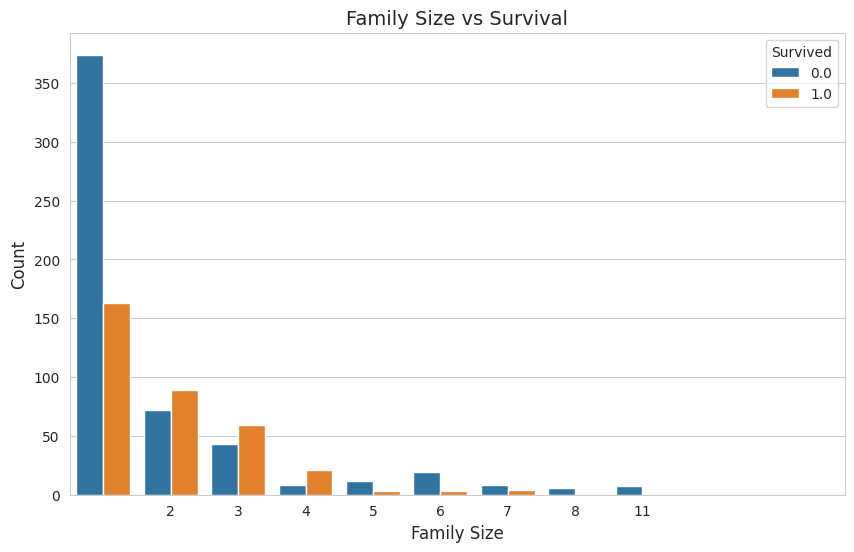

In [19]:
# Create a count plot to visualize the relationship between family size and survival
plt.figure(figsize=(10, 6))
sns.countplot(x='Fsize', hue='Survived', data=full[:891], dodge=True)

# Customize the plot
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Family Size vs Survival', fontsize=14)
plt.xticks(range(1, 12))  # Set family size categories from 1 to 11
plt.show()

<Figure size 800x600 with 0 Axes>

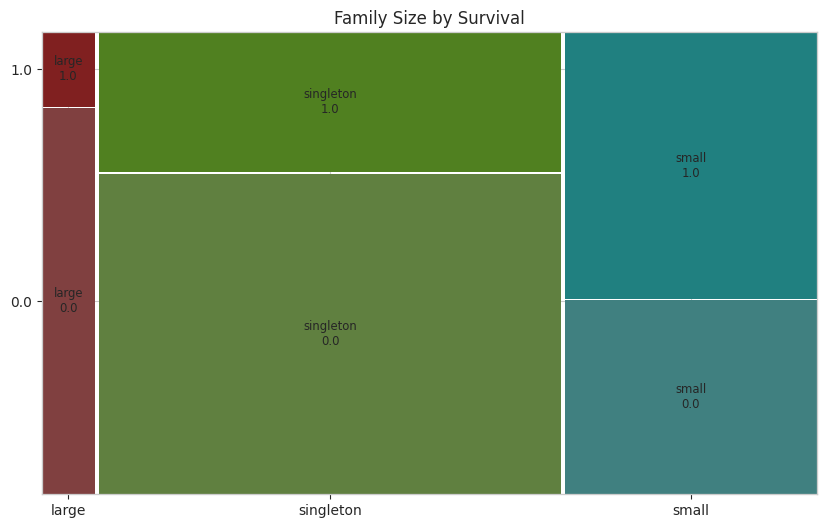

In [20]:
# Discretize family size
conditions = [
    (full['Fsize'] == 1),
    (full['Fsize'] > 1) & (full['Fsize'] < 5),
    (full['Fsize'] > 4)
]

choices = ['singleton', 'small', 'large']
full['FsizeD'] = np.select(conditions, choices, default='unknown')

# Show family size by survival using a mosaic plot
contingency_table = pd.crosstab(full['FsizeD'], full['Survived'])
plt.figure(figsize=(8, 6))
mosaic(contingency_table.stack(), title='Family Size by Survival')
plt.show()

##2.3 Treat a few more variables …

In [21]:
# This variable appears to have a lot of missing values
print(full['Cabin'].head(28))

0             NaN
1             C85
2             NaN
3            C123
4             NaN
5             NaN
6             E46
7             NaN
8             NaN
9             NaN
10             G6
11           C103
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            D56
22            NaN
23             A6
24            NaN
25            NaN
26            NaN
27    C23 C25 C27
Name: Cabin, dtype: object


In [22]:
# The first character is the deck. For example:
full['Deck'] = full['Cabin'].apply(lambda x: str(x)[0] if isinstance(x, str) and len(x) > 0 else np.nan)
# Create a Deck variable. Get passenger deck A - F:
full['Deck'] = full['Cabin'].apply(lambda x: str(x)[0] if isinstance(x, str) and len(x) > 0 else np.nan)
print(full[['Cabin', 'Deck']].head(10))

  Cabin Deck
0   NaN  NaN
1   C85    C
2   NaN  NaN
3  C123    C
4   NaN  NaN
5   NaN  NaN
6   E46    E
7   NaN  NaN
8   NaN  NaN
9   NaN  NaN


#3.Missingness

##3.1 Sensible value imputation

In [23]:
# Passengers 62 and 830 are missing Embarkment
full.loc[(full['Embarked'].isna()) | (full['Embarked'] == ''), 'Embarked']
print(full.loc[(full['Embarked'].isna()) | (full['Embarked'] == ''), ['PassengerId', 'Pclass', 'Fare', 'Embarked']])

     PassengerId  Pclass  Fare Embarked
61            62       1  80.0      NaN
829          830       1  80.0      NaN
